# LiDAR Point Cloud Filter

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from mob_pc_helper import MOB_Point_Cloud_Helper
mob_pc_helper = MOB_Point_Cloud_Helper()

#### Project lidar point cloud to image

Let we start with take a look at RGB image

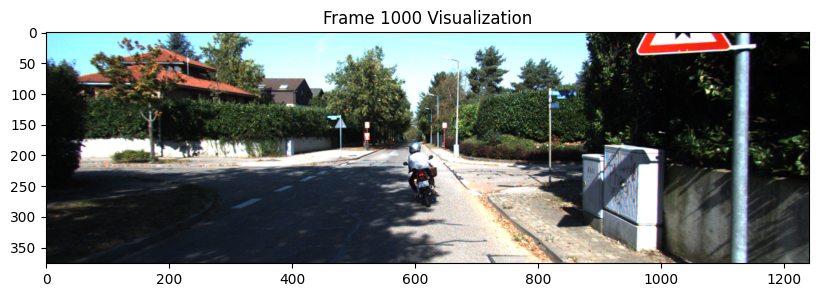

In [2]:
image = mob_pc_helper.read_image('./data/image_02/data/0000001000.png')
plt.subplots(1,1, figsize = (13,3))
plt.title("Frame 1000 Visualization")
plt.imshow(image)

Please now implement the function lidar_pc_to_cam() for projecting lidar 3D points to camera 2D image plane.

We have provided you with rotational matrix and translational matrix from lidar coordinates to camera coordinates

We also provided you the camera projection matrix

In [325]:
R = np.array([7.967514e-03,-9.999679e-01,-8.462264e-04,-2.771053e-03,8.241710e-04,-9.999958e-01,9.999644e-01,7.969825e-03,-2.764397e-03])
T = np.array([-1.377769e-02,-5.542117e-02,-2.918589e-01])
R = R.reshape(3,3) # Rotation matrix
#print(R)
T = T.reshape(3, 1) # Translation matrix

RT = np.hstack((R, T)) # Transformation matrix
#RT = np.vstack((RT, np.array([0, 0, 0, 1]))) # Transformation matrix
#print(Tr)

P = np.array([7.188560e+02,0.000000e+00,6.071928e+02,0.000000e+00,0.000000e+00,7.188560e+02,1.852157e+02,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00])
P = P.reshape(3, 4)
P = P[:3, :3] # Camera projection matrix
#print(P)

In [326]:
def lidar_pc_to_cam(lidar_pc):
    xyz_v, point_colour = mob_pc_helper.crop_pc_and_reformat(lidar_pc)
    # xyz_v - shape (4,n) numpy array that contains n lidar points information (x,y,z,intensity)
    # point_colour - shape (n,) numpy array that contains colours information for each point,
    #                it will useful for later visualisation. Your implementation
    #                should have nothing to do with colour
    # START of your implementation  

    # convert xyz_v to xyz_v_cam 
    for i in range(xyz_v.shape[1]):
        xyz_v[:3,i] = np.matmul(RT, xyz_v[:,i])

    xyz_c = np.delete(xyz_v, 3, axis=0)

    # convert camera coordinates(X_c, Y_c, Z_c) image(pixel) coordinates(x,y) 
    for i in range(xyz_c.shape[1]):
        xyz_c[:,i] = np.matmul(P, xyz_c[:,i])    

    xy_i = xyz_c[::]/xyz_c[::][2]
    pc_in_img = np.delete(xy_i, 2, axis=0)
    return pc_in_img, point_colour

    # END of your implementation
    # pc_in_img - shape (2,n) numpy array that contains projected lidar points on image plane
    # point_colour - should remain the same

If your implementation is correct, you should now able to see the point cloud has been project to the image

65062


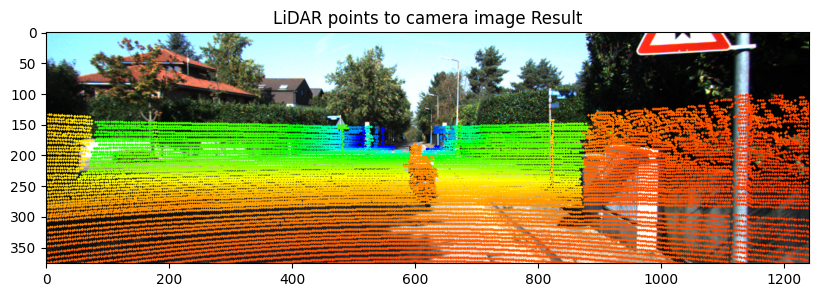

In [332]:
lidar_pc = mob_pc_helper.read_lidar('./data/velodyne_points/0000001000.bin')
lidar_pc_in_img, point_colour = lidar_pc_to_cam(lidar_pc)
print(len(lidar_pc_in_img[1]))
# display result image
plt.subplots(1,1, figsize = (13,3))
plt.title("LiDAR points to camera image Result")
plt.imshow(mob_pc_helper.add_projection_on_img(lidar_pc_in_img, point_colour, image))

#### Filter Point Cloud

Let we start with some bounding boxes visualization

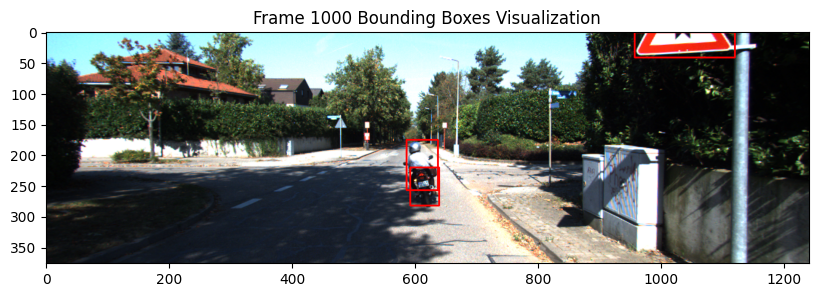

In [328]:
label = mob_pc_helper.read_label('./data/labels/0000001000.txt')
image = mob_pc_helper.read_image('./data/image_02/data/0000001000.png')
bbox_image, bbox_list = mob_pc_helper.add_bbox_on_img(image, label)
plt.subplots(1,1, figsize = (13,3))
plt.title("Frame 1000 Bounding Boxes Visualization")
plt.imshow(bbox_image)

Now please implement the function filter_in_bbox_points() to remove all the points that is in the bounding boxes

In [329]:
def filter_in_bbox_points(points, point_colours, bbox):
    # points - shape (2,n) numpy array that contains projected lidar points on image plane
    # point_colour - shape (n,) numpy array that contains colours information for each point
    # bbox - shape (m,4) numpy array that contains bounding boxes information.
    #        Each element in array is a size=4 array of [x1,y1,x2,y2]
    #        Where x1,y1 are the bottom left coordinates of bounding boxes,
    #        and x2,y2 are the top right coordinates of bounding boxes.
    # START of your implementation
    # filter out points that are not in the bounding box
    filter_points = points
    filter_colours = point_colours
    for i in range(len(bbox)): 
        numpoints = 0   
        for j in range(len(points[1])): 
            if points[0][j] >= bbox[i][0] and points[0][j] <= bbox[i][2] and points[1][j] >= bbox[i][1] and points[1][j] <= bbox[i][3]:
                #set the points that are in the bounding box to 0
                filter_points[0][j] = 0
                filter_points[1][j] = 0
                filter_colours[j] = 0
                numpoints+=1
    # END of your implementation
    # filter_points - shape (2,c) numpy array that contains filtered projected lidar points on image plane
    # point_colour - shape (c,) numpy array that contains colours information for each filtered point
    return filter_points, filter_colours

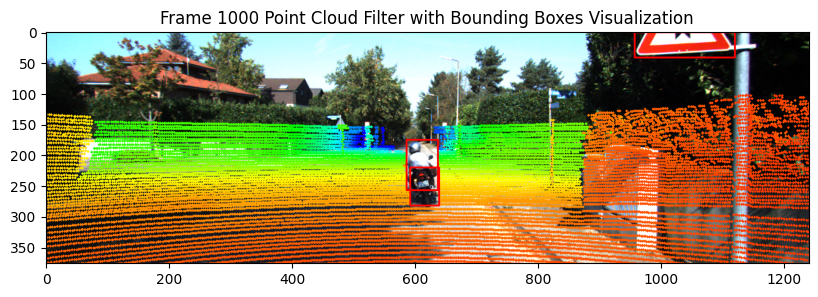

In [321]:
filter_points, filter_colours = filter_in_bbox_points(lidar_pc_in_img, point_colour, bbox_list)
image_with_pc = mob_pc_helper.add_projection_on_img(filter_points, filter_colours, image)
bbox_image, bbox_list = mob_pc_helper.add_bbox_on_img(image_with_pc, label)
plt.subplots(1,1, figsize = (13,3))
plt.title("Frame 1000 Point Cloud Filter with Bounding Boxes Visualization")
plt.imshow(bbox_image)